In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats
from nba_api.stats.endpoints.leaguedashplayerclutch import LeagueDashPlayerClutch

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats

In [4]:
clutch_df = LeagueDashPlayerClutch(season='2021-22', per_mode_detailed='Totals', ahead_behind='Behind or Tied', clutch_time='Last 1 Minute', point_diff='3').get_data_frames()[0]

In [8]:
clutch_df.loc[:, ['PLAYER_NAME', 'FGM', 'FGA', 'FG3M', 'FG3A', 'PTS']]

,PLAYER_NAME,FGM,FGA,FG3M,FG3A,PTS
0,Aaron Gordon,1,1,1,1,3
1,Aaron Holiday,0,0,0,0,0
2,Al Horford,0,0,0,0,0
3,Alec Burks,0,0,0,0,0
4,Alex Caruso,0,0,0,0,0
5,Alex Len,0,0,0,0,0
6,Andre Drummond,0,0,0,0,0
7,Andre Iguodala,0,0,0,0,0
8,Andrew Wiggins,0,0,0,0,0
9,Anfernee Simons,0,0,0,0,0


In [9]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(2008, 2022)]

In [36]:
data = {}
for season in seasons:
    clutch_df = LeagueDashPlayerClutch(season=season, per_mode_detailed='Totals', ahead_behind='Behind or Tied', clutch_time='Last 1 Minute', point_diff='3', season_type_all_star='Regular Season').get_data_frames()[0]
    subset = clutch_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'FGM', 'FGA', 'FG3M', 'FG3A', 'PTS']]
    for i in range(len(subset)):
        item = subset.iloc[i]
        if item.PLAYER_NAME not in data:
            data[item.PLAYER_NAME] = {
                'PLAYER_ID': item.PLAYER_ID,
                'FGM': 0,
                'FGA': 0,
                'FG3M': 0,
                'FG3A': 0,
                'PTS': 0
            }
        data[item.PLAYER_NAME]['FGM'] += item.FGM
        data[item.PLAYER_NAME]['FGA'] += item.FGA
        data[item.PLAYER_NAME]['FG3M'] += item.FG3M
        data[item.PLAYER_NAME]['FG3A'] += item.FG3A
        data[item.PLAYER_NAME]['PTS'] += item.PTS
    time.sleep(0.2)

In [37]:
reformat_data = []
for key in data:
    reformat_data.append(
        {
            'PLAYER_NAME': key,
            **data[key]
        }
    )

In [38]:
df = pd.DataFrame(reformat_data)

In [39]:
df.loc[:, 'EFG'] = ((df.FGM + df.FG3M * 0.5) / df.FGA * 100).round(2)

In [40]:
sorted_df = df.sort_values(by='FGA', ascending=False)

In [41]:
sorted_df = sorted_df.iloc[:30]

In [42]:
plt.style.use('fivethirtyeight')

In [44]:
from pathlib import Path

In [48]:
for index in tqdm.tqdm(range(len(sorted_df))):
    item = sorted_df.iloc[index]
    #team_id = item.TEAM_ID
    player_id = item.PLAYER_ID
    img_path = Path(f'player_imgs/{player_id}.png')
    if img_path.exists():
        continue
    print(item.PLAYER_NAME)
    #img = Image.open(f'player_imgs/{player_id}.png')
    #if img.size[0] < 400:
    #    continue
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

  0%|                                                                                                                                                                                        | 0/30 [00:00<?, ?it/s]

Dwyane Wade


 27%|██████████████████████████████████████████████▉                                                                                                                                 | 8/30 [00:00<00:00, 26.61it/s]

Rudy Gay


 33%|██████████████████████████████████████████████████████████▎                                                                                                                    | 10/30 [00:00<00:01, 16.00it/s]

Kobe Bryant


 37%|████████████████████████████████████████████████████████████████▏                                                                                                              | 11/30 [00:00<00:02,  7.85it/s]

Monta Ellis


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 15/30 [00:01<00:01,  9.23it/s]

Kyrie Irving


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 16/30 [00:01<00:02,  6.72it/s]

Joe Johnson


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 17/30 [00:01<00:02,  5.84it/s]

John Wall


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 18/30 [00:01<00:02,  5.21it/s]

Dirk Nowitzki


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 24/30 [00:02<00:00,  6.85it/s]

DeMarcus Cousins


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 26/30 [00:02<00:00,  7.15it/s]

Deron Williams
Tyreke Evans


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 28/30 [00:02<00:00,  5.75it/s]

Paul Pierce


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.91it/s]


In [49]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=1.0):
    #print(path)
    return OffsetImage(plt.imread(path), zoom=zoom)


In [50]:
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick


Text(0.5, 1.0, 'Players in Clutch when tied or behind by 3 or less points (since 08-09)')

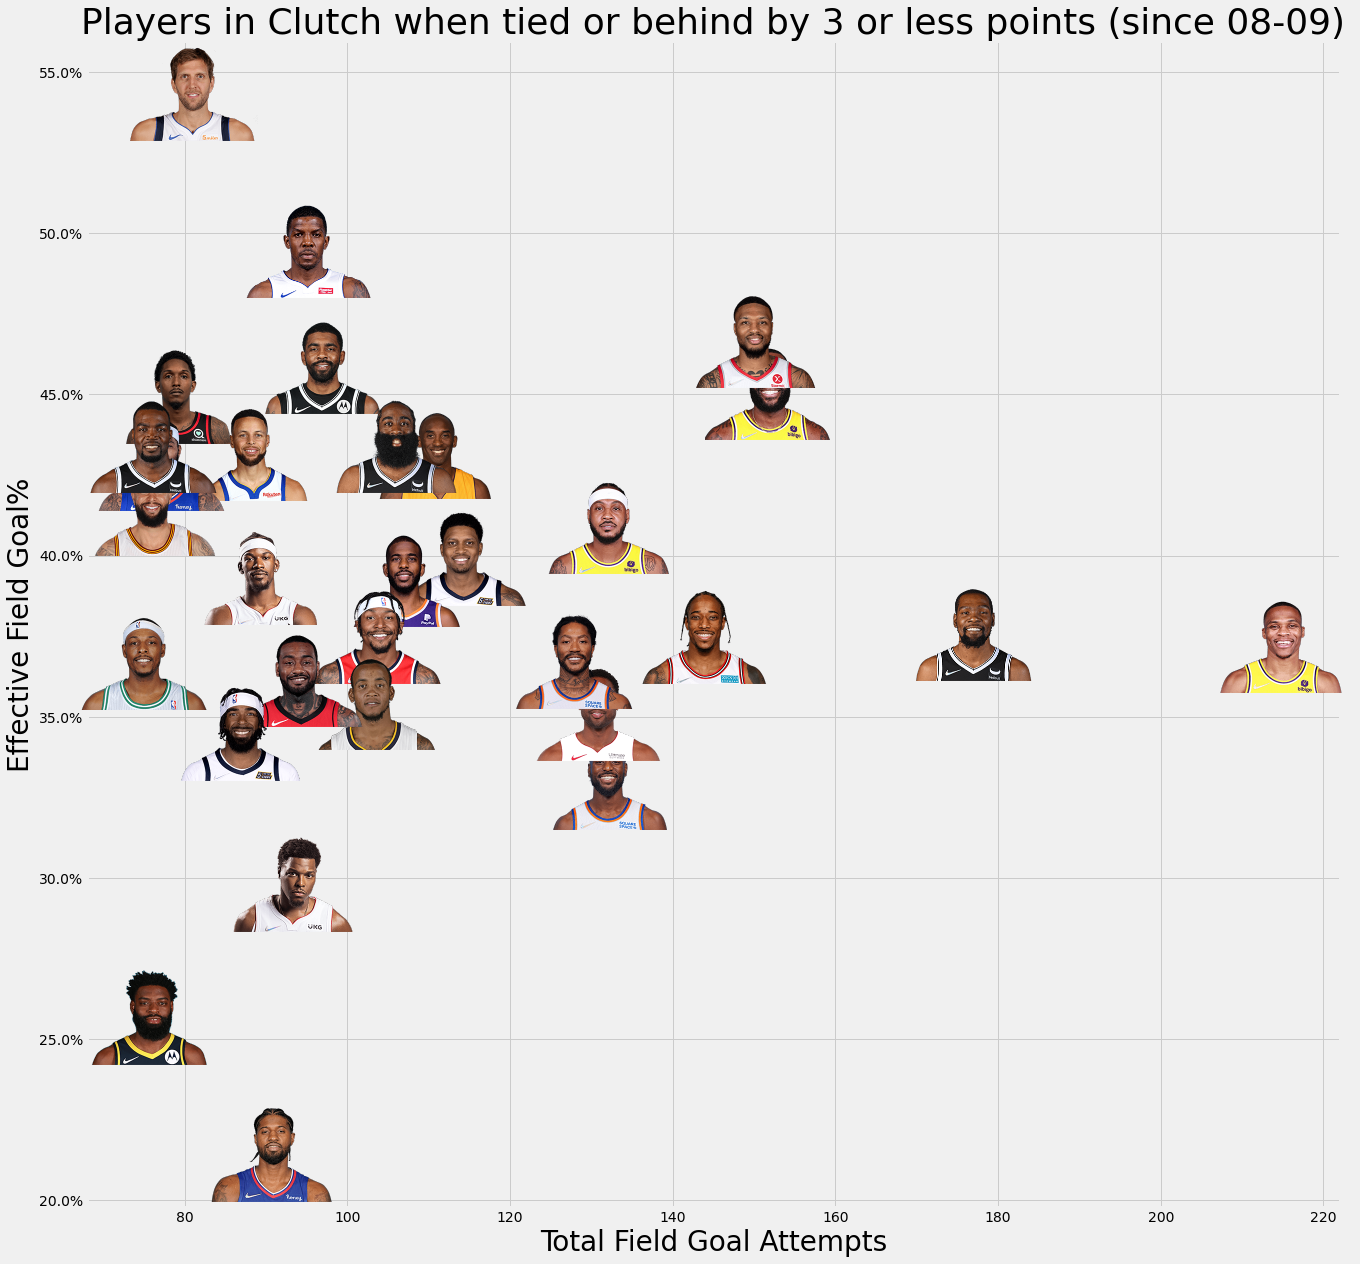

In [58]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=sorted_df.FGA, y=sorted_df.EFG, s=30)

x = sorted_df.FGA.tolist()
y = sorted_df.EFG.tolist()
paths = []
for i in range(len(sorted_df)):
    item = sorted_df.iloc[i]
    paths.append(f'player_imgs/{item.PLAYER_ID}.png')

for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path, zoom=0.5), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_xlabel("Total Field Goal Attempts", size=28)
ax.set_ylabel("Effective Field Goal%", size=28)

ax.set_title("Players in Clutch when tied or behind by 3 or less points (since 08-09)", size=36)